In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv("Train.csv")
data.head()
print(data.shape)

(10999, 12)


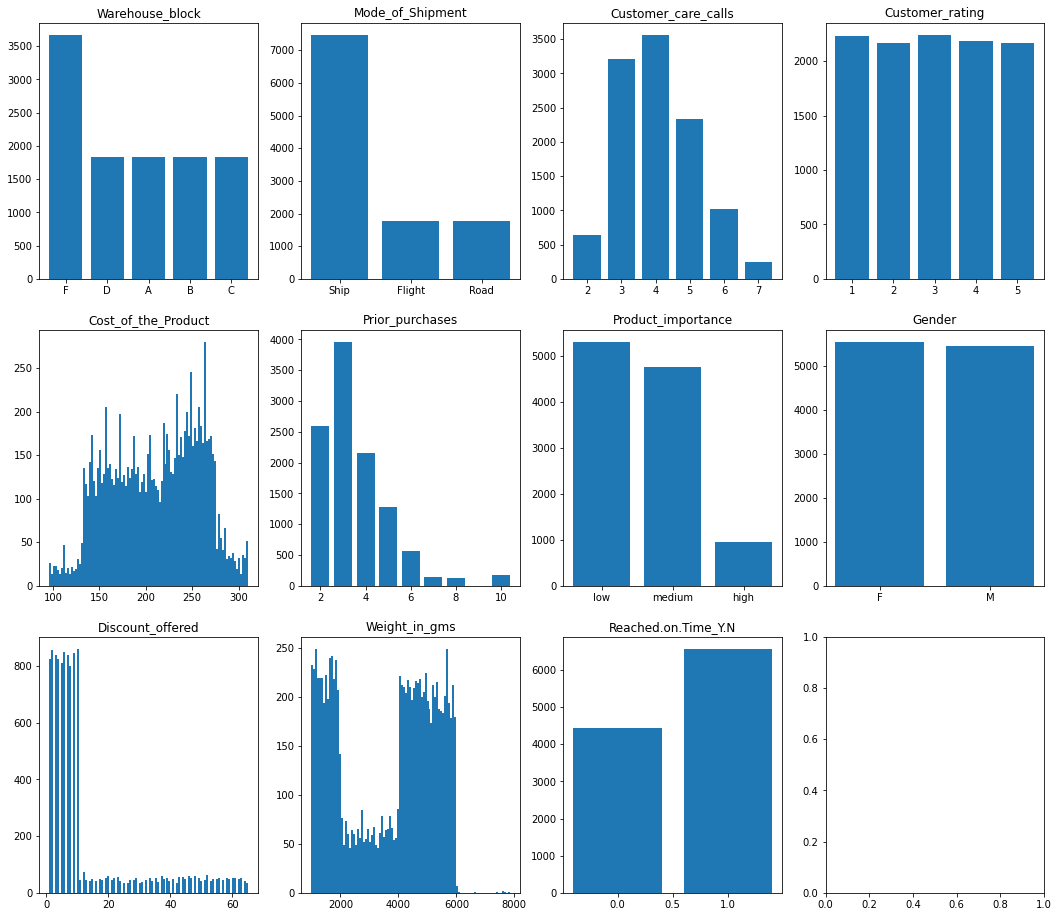

In [111]:
# Data Exploration
from pandas.api.types import is_numeric_dtype

fig, axs = plt.subplots(3, 4, figsize = (18, 16))
axs_flat = axs.flatten()
for i, column in enumerate(data.columns[1: ]):
    subset = data[column]
    if is_numeric_dtype(subset) and subset.nunique() > 10:
        axs_flat[i].hist(subset, bins = 100)
    else:
        value_counts = subset.value_counts()
        axs_flat[i].bar(x = value_counts.index, height = value_counts.values)
    axs_flat[i].set_title(column)

plt.show()

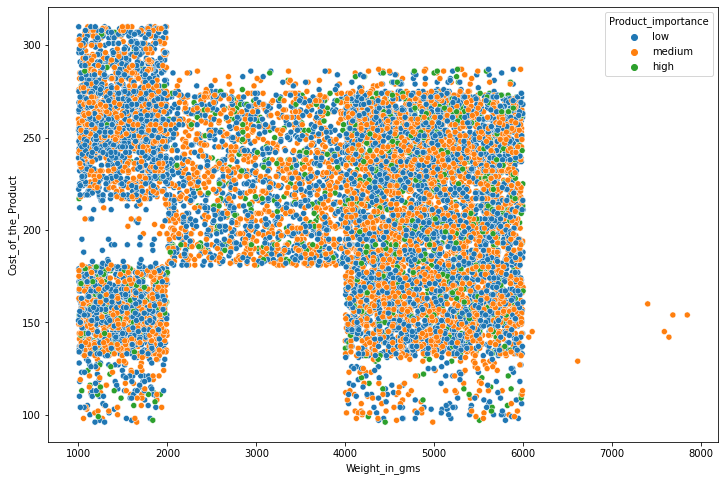

In [24]:
# Do heavier products weigh more? Do important products cost more?

plt.figure(figsize = (12, 8))
sns.scatterplot(
    data = data, 
    x = "Weight_in_gms", 
    y = "Cost_of_the_Product", 
    hue = "Product_importance"
)
plt.show()

No clear relationship between weight and product cost

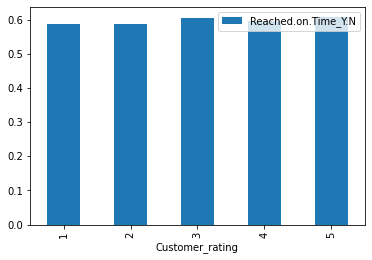

In [29]:
# Does higher customer ratings lead to more on time deliveries?

data.groupby("Customer_rating").mean()[["Reached.on.Time_Y.N"]].plot(kind = "bar")
plt.show()

Delivery times are irrespective of customer ratings

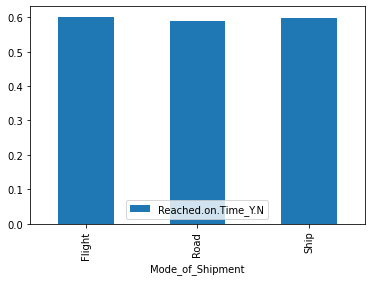

In [32]:
# How do shipment methods affect shipment times?

data.groupby("Mode_of_Shipment").mean()[["Reached.on.Time_Y.N"]].plot(kind = "bar")
plt.show()

Product delivery times are irrespective of shipment modes

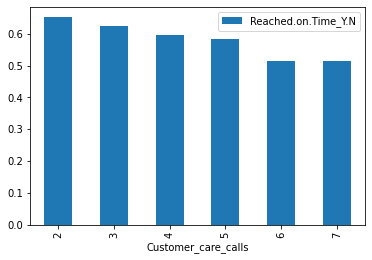

In [37]:
# If a customer makes more calls, would their product be more likely to arrive on time?

data.groupby("Customer_care_calls").mean()[["Reached.on.Time_Y.N"]].plot(kind = "bar")
plt.show()

There is slight decrease in average products that arrived on time. Since the variable is labelled 
1 for products that do not arrive on time, a decrease would indicate more products arriving on time

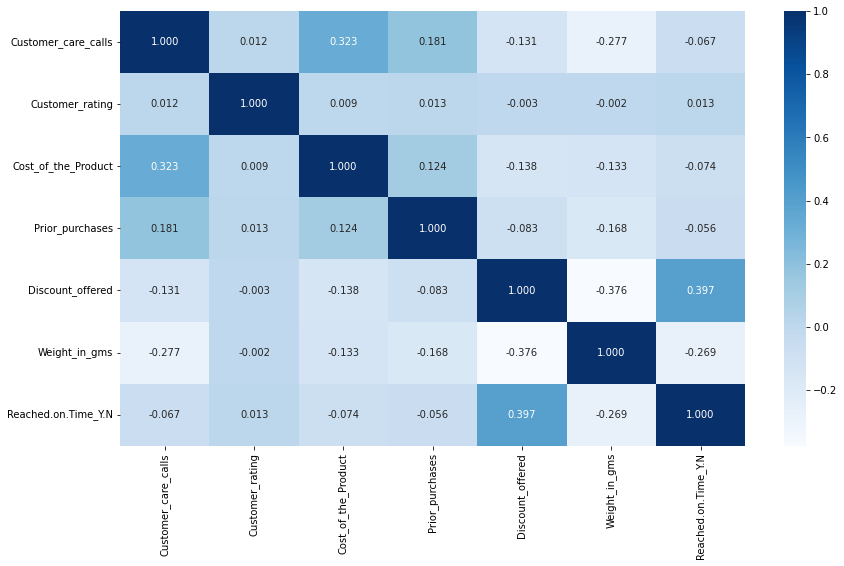

In [41]:
# Plot the correlation matrix

plt.figure(figsize = (14, 8))
sns.heatmap(
    data.drop(columns = "ID").corr(),
    cmap = "Blues",
    annot = True,
    fmt = ".3f"
)
plt.show()

We find that the discounts offered and product weight are more strongly correlated with the target

In [51]:
# Prepare the data for model training
from sklearn.preprocessing import LabelEncoder

numeric = data.drop(columns = "ID").select_dtypes(exclude = [object])
categoric = data.drop(columns = "ID").select_dtypes(include = [object])

onehot_encode = ["Warehouse_block", "Mode_of_Shipment", "Gender"]
label_encode = ["Product_importance"]

categoric_encoded = pd.get_dummies(data[onehot_encode])

encoder = LabelEncoder()
for column in label_encode:
    subset = categoric[column]
    encoded = encoder.fit_transform(subset)
    categoric_encoded = pd.concat([categoric_encoded, pd.Series(encoded, name = column)], axis = 1)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

model_data = pd.concat([numeric, categoric_encoded], axis = 1)
model_data

features = model_data.drop(columns = "Reached.on.Time_Y.N")
target = model_data["Reached.on.Time_Y.N"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 242)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix

logreg = LogisticRegression()
logreg_cv = cross_validate(logreg, X_train, y_train, cv = 5)

print("Logistic Regression CV mean accuracy score", np.mean(logreg_cv["test_score"]))

Logistic Regression CV mean accuracy score 0.6404711273132326


In [73]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_cv = cross_validate(gnb, X_train, y_train, cv = 5)

print("Naive Bayes CV mean accuracy score", np.mean(gnb_cv["test_score"]))

Naive Bayes CV mean accuracy score 0.6573557631452369


In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

dectree = DecisionTreeClassifier()
dectree_cv = cross_validate(dectree, X_train, y_train, cv = 5)

print("Decision Tree CV mean accuracy score", np.mean(dectree_cv["test_score"]))

Decision Tree CV mean accuracy score 0.6411214062091256


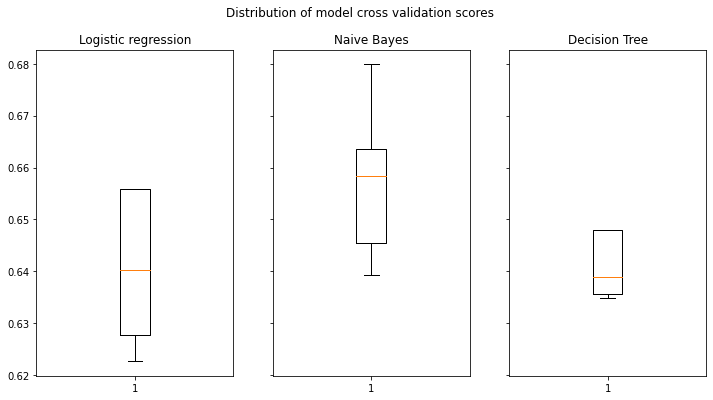

In [81]:
fig, axs = plt.subplots(1, 3, figsize = (12, 6), sharey = True)

axs[0].boxplot(logreg_cv["test_score"])
axs[0].set_title("Logistic regression")

axs[1].boxplot(gnb_cv["test_score"])
axs[1].set_title("Naive Bayes")

axs[2].boxplot(dectree_cv["test_score"])
axs[2].set_title("Decision Tree")

plt.suptitle("Distribution of model cross validation scores")
plt.show()

Naive bayes has the largest average accuracy across the 3 models, and have a better distribution in terms of accuracy score

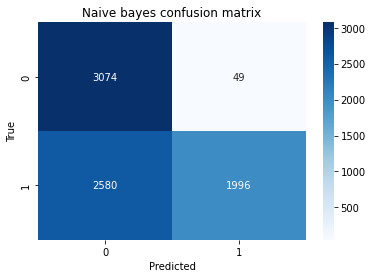

In [93]:
gnb.fit(X_train, y_train)

train_pred = gnb.predict(X_train)
train_cnfm = confusion_matrix(y_train, train_pred)

sns.heatmap(
    train_cnfm,
    cmap = "Blues",
    annot = True,
    fmt = ".0f"
)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Naive bayes confusion matrix")
plt.show()

Naive bayes seems to have a preference to predict 0s.

In [115]:
# Test naive bayes out of sample accuracy

test_pred = gnb.predict(X_test.values)
test_score = accuracy_score(y_test, test_pred)
print("Naive bayes test score", test_score)

Naive bayes test score 0.6021212121212122


Slight overfitting observed in naive bayes